# Computational Finance

## Lab Assignment 3

This notebook makes use of python 3 environment by default.

Authors:
   - Kevin de Vries
   - Jedda Boyle
   - Krishnakanth Sasi
   
Student Numbers:
   - 10579869
   - 11398221
   - 11391952

In [27]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.sparse import diags
from scipy.stats import norm
from numpy.linalg import inv

from tqdm import tqdm

# Finite-Difference implementation

In [28]:
class PDE(object):
    def __init__(self, K, sigma, r, T, X_bounds, N, M, scheme, boundary):
        """
        Initializes the PDE object
        
        K: integer/float
            Strike price
        sigma: float
            Volatility
        r: float
            Risk free interest rate
        T: integer/float
            Time until maturity
        S_bounds: tuple
            (minimum, maximum) stock price
        N: integer
            Number of time nodes
        M: integer
            Number of space nodes
        scheme: String
            String containing the Finite Difference scheme to use
        boundary: String
            String containing the boundary value type to use
        """
        
        # Set parameters
        self.sigma = sigma
        self.r = r
        self.K = K
        self.T = T
        
        # Calculate time steps
        self.dtau = T / N
        
        # Calculate boundaries of X and step size of X
        self.Xmin = np.log(S_bounds[0])
        self.Xmax = np.log(S_bounds[1])
        self.dx = (self.Xmax-self.Xmin) / (M-1)
        
        # Set dimensions of the mesh grid
        self.N = N
        self.M = M
        
        # Set scheme type
        self.scheme = scheme
        
        # Set boundary value type
        self.boundary = boundary
        
        # Initialize Value matrix and calculate initial values
        self.V = np.zeros((M,N+1))
        self.V[:,0] = np.maximum(np.exp(self.Xmin + self.dx*np.arange(0,M)) - K, 0)
                
    def run(self):
        """
        Run the finite difference solver
        """
        
        # Set parameters
        r = self.r
        sigma = self.sigma
        K = self.K
        T = self.T
        dx = self.dx
        dtau = self.dtau
        
        self.create_params()
        
        aplus = self.a[2]
        
        if scheme == "Crank_Nicolson":
            self.BMatrix()
        
        if self.boundary == "Neumann":
            k = (r - 0.5*sigma**2 + sigma**2 / dx) * dtau * np.exp(self.Xmax)
        
        for n in range(1,self.N+1):
            
            if self.boundary == "Dirichlet":
                k = aplus*(np.exp(self.Xmax+dx) - K*np.exp(-r*(T-n*dtau)))
                if scheme == "Crank_Nicolson":
                    k *= 2

            self.V[:,n] = self.AprodV(self.V[:,n-1])
            self.V[-1, n] += k
            
            if scheme == "Crank_Nicolson":
                self.V[:,n] = self.Binv @ self.V[:,n]

In [29]:
# Krish's functions section

def create_params(self):
    """
    Creates and stores a and b parameters as tuples in self
    """
    
    # Shorten object parameters
    r = self.r
    sigma = self.sigma
    dtau = self.dtau
    dx = self.dx
    
    # a0 for FTCS
    AF0 = 1 - (sigma**2)*dtau/dx**2 - r*dtau
    
    # Plus and minus components for both a and b and for both schemes
    P1 = 0.5 * ( (sigma**2)*dtau/dx**2 - (r - 0.5*(sigma**2))*dtau/dx )
    P2 = 0.5 * ( (sigma**2)*dtau/dx**2 + (r - 0.5*(sigma**2))*dtau/dx )
    
    # a0 and b0 for Crank-Nicolson scheme
    AC0 = 1 - 0.5*(sigma**2)*dtau/dx**2 - 0.5*r*dtau
    BC0 = 1 + 0.5*(sigma**2)*dtau/dx**2 + 0.5*r*dtau
    
    if self.scheme == "FTCS":
        self.a = [P1, AF0, P2]
        self.b = [0, 1, 0]
    if self.scheme == "Crank_Nicolson":
        self.a = [P1*0.5, AC0, P2*0.5]
        self.b = [-P1*0.5, BC0, -P2*0.5]

def BMatrix(self):
    """
    Creates and stores inverse of a B matrix in an object
    """
    bmin, b0 , bplus = self.b
    
    diagonals = [b0*np.ones(self.M), bplus*np.ones(self.M-1), bmin*np.ones(self.M-1)]
    
    self.B = diags(diagonals, [0, 1, -1]).toarray()
    
    # Change bmin for last V when using Von Neumann boundary conditions
    if self.boundary == "Neumann":
        self.B[-1,-2] = -0.5 * self.sigma**2 * self.dtau / self.dx**2
    
    self.Binv = inv(self.B)

In [30]:
# Kevin's code section

def AprodV(self,v):
    """
    Calculates the sparse matrix product of A with v
    """
    amin, a0, aplus = self.a
    
    res = np.zeros(v.size)
    
    # Calculate v_1 and v_M using boundary conditions
    res[0] = a0*v[0] + aplus*v[1]
    
    if self.boundary == "Neumann":
        # Change product calculation in last row
        temp = self.sigma**2 * self.dtau / self.dx**2
        
        if self.scheme == "Crank_Nicolson":
            temp *= 0.5
        
        res[v.size-1] = temp*v[-2] + a0*v[-1]
        
    elif self.boundary == "Dirichlet":
        res[v.size-1] = amin*v[-2] + a0*v[-1]
    
    # Calculate the rest of the fucking vector
    res[1:v.size-1] = amin*v[:v.size-2] + a0*v[1:v.size-1] + aplus*v[2:]
    return res

def get_values(self):
    """
    Returns option values at t = 0
    """
    return np.copy(self.V[:,-1])

def get_X(self):
    """
    Returns spacial node values (log of stock price)
    """
    return self.Xmin + self.dx*np.arange(0,self.M)

def get_stock_prices(self):
    """
    Returns stock prices for each spacial node
    """
    return np.exp(self.get_X())

def plot_grid(self):
    """
    Plots option values per grid point as a density plot
    """
    plt.imshow(self.V,origin='lower',cmap='gray_r')
    plt.colorbar()
    plt.xlabel("n")
    plt.ylabel("i")

def get_deltas(self):
    """
    Calculates hedge parameters for all spacial nodes at t = 0
    """
    deltas = np.zeros(self.M)
    
    deltas[0,] = 0
    deltas[-1] = np.exp(self.Xmax)
    
    deltas[1:self.M-1] = (self.V[2:self.M,-1] - self.V[0:self.M-2,-1]) / (2*self.dx)
    
    deltas *= np.exp(-(self.Xmin + np.arange(0,self.M)*self.dx))
        
    return deltas

In [31]:
# Add functions to class
PDE.create_params = create_params
PDE.BMatrix = BMatrix
PDE.AprodV = AprodV
PDE.get_values = get_values
PDE.get_stock_prices = get_stock_prices
PDE.get_X = get_X
PDE.get_deltas = get_deltas
PDE.plot_grid = plot_grid

In [32]:
# Misc functions

# Black Scholes formula
def black_scholes(r, K, T, S_0, sigma, call=True):
    '''
    Calculates the Hedge ratio, call or put price
    
    Parameters
        r: float
            Interest rate
        K: float
            Strike price
        T: int
            Time of maturity
        S_0: float
            Current stock price
        sigma: float
            Volatility
        call: bool
            check if call or put
        
    Returns
        delta: float
            Hedge ratio
        price: float
            Call or put price
    '''
    d1 = (np.log(S_0/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*(T**0.5) 
    N1 = norm.cdf(d1)
    N2 = norm.cdf(d2)
    N3 = norm.cdf(-d1)
    N4 = norm.cdf(-d2)
    
    if call:
        price = S_0*N1 - K*np.exp(-r*T)*N2
        delta = N1
    else:
        price = K*np.exp(-r*T)*N4 - S_0*N3
        delta = N1 - 1
    
    return delta, price 

def interpolate(x,x0,x1,y0,y1):
    return (y0*(x1-x)+y1*(x-x0)) / (x1-x0)

def analyze_convergence(K,sigma,r,T,S_bounds,N,M_list,scheme,boundary):
    S0_prices = np.zeros((3,M_list.size))
    with tqdm(total=M_list.size, disable=False) as pbar:
        for m in range(M_list.size):
            pde = PDE(K, sigma, r, T, S_bounds, N, M_list[m], scheme, boundary)
            pde.run()

            X = pde.get_X()
            V = pde.get_values()
    
            for n in range(3):
                S0 = 100 + n*10
                X0 = np.log(S0)
            
                Vmin = (V[X < X0])[-1]
                Vmax = (V[X >= X0])[0]
                Xmin = (X[X < X0])[-1]
                Xmax = (X[X >= X0])[0]

                res = interpolate(X0,Xmin,Xmax,Vmin,Vmax)
            
                S0_prices[n,m] = res

            pbar.update()
    
    return S0_prices

# Test Finite-Difference implementation

In [33]:
sigma,r,T = 0.3, 0.04, 1
K = 110
S_bounds = 0.001, 1000
N, M = 1000, 1000

#scheme = "FTCS"
scheme = "Crank_Nicolson"

#boundary = "Dirichlet"
boundary = "Neumann"

test = PDE(K, sigma, r, T, S_bounds, N, M, scheme, boundary)

test.run()

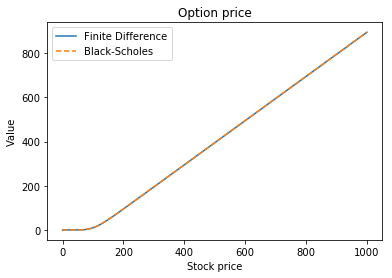

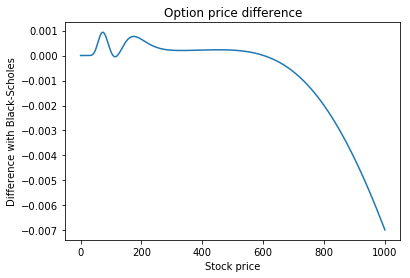

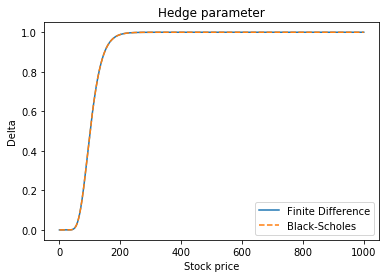

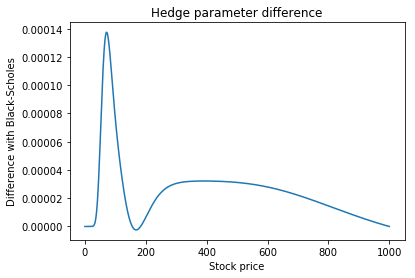

In [34]:
S = test.get_stock_prices()
X = test.get_X()
V = test.get_values()
D = test.get_deltas()

BS_delta, BS_price = black_scholes(r, K, T, S, sigma)

# Price
plt.title("Option price")
plt.xlabel("Stock price")
plt.ylabel("Value")
plt.plot(S,V,label="Finite Difference")
plt.plot(S,BS_price,'--',label="Black-Scholes")
plt.legend()
plt.show()

plt.title("Option price difference")
plt.xlabel("Stock price")
plt.ylabel("Difference with Black-Scholes")
plt.plot(S,V-BS_price)
plt.show()

# Delta
plt.title("Hedge parameter")
plt.xlabel("Stock price")
plt.ylabel("Delta")
plt.plot(S,D,label="Finite Difference")
plt.plot(S,BS_delta,'--',label="Black-Scholes")
plt.legend()
plt.show()

plt.title("Hedge parameter difference")
plt.xlabel("Stock price")
plt.ylabel("Difference with Black-Scholes")
plt.plot(S,D-BS_delta)
plt.show()

In [35]:
S0 = 120
X0 = np.log(S0)

Vmin = (V[X < X0])[-1]
Vmax = (V[X >= X0])[0]
Xmin = (X[X < X0])[-1]
Xmax = (X[X >= X0])[0]

V0 = interpolate(X0,Xmin,Xmax,Vmin,Vmax)

_, BS_val = black_scholes(r, K, T, S0, sigma)

print("Stock price at t = 0: %f\n" % S0)

print("PDE price: %f\n" % V0)
print("Black-Scholes price: %f\n" % BS_val)

Stock price at t = 0: 120.000000

PDE price: 21.793373

Black-Scholes price: 21.788808



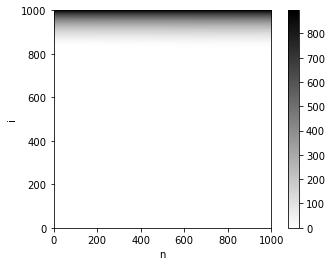

In [36]:
test.plot_grid()
plt.show()

# Mesh size Analysis

In [37]:
sigma, r, T = 0.3, 0.04, 1
K = 110
S_bounds = 0.001, 1000

BS_deltas, BS_prices = black_scholes(r, K, T, np.array([100,110,120]), sigma)

N = 1000
M_list = np.arange(100,9001,100)

Xmin = np.log(S_bounds[0])
Xmax = np.log(S_bounds[1])

dx_list = (Xmax-Xmin) / (M_list-1)

# Crank_Nicolson
scheme = "Crank_Nicolson"
#S0_prices = analyze_convergence(K,sigma,r,T,S_bounds,N,M_list,scheme,"Neumann")

In [38]:
# Save data for potential later use
#np.save("data/convergence_Crank_Nicolson.npy",S0_prices)

# Load data
S0_prices = np.load("data/convergence_Crank_Nicolson.npy")

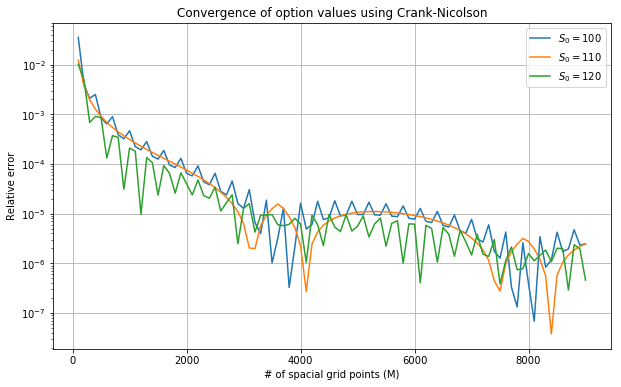

In [39]:
S100,S110,S120 = np.abs((S0_prices-BS_prices[:,None]) / BS_prices[:,None])

plt.figure(figsize=(10,6))
plt.title("Convergence of option values using Crank-Nicolson")
plt.xlabel("# of spacial grid points (M)")
plt.ylabel("Relative error")

plt.grid(True)
plt.yscale("log")

plt.plot(M_list,S100,label=r'$S_0 = 100$')
plt.plot(M_list,S110,label=r'$S_0 = 110$')
plt.plot(M_list,S120,label=r'$S_0 = 120$')

plt.legend()
plt.show()

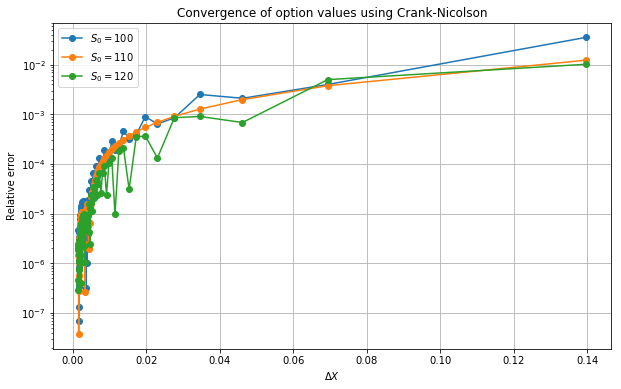

In [40]:
plt.figure(figsize=(10,6))
plt.title("Convergence of option values using Crank-Nicolson")
plt.xlabel(r"$\Delta X$")
plt.ylabel("Relative error")

plt.grid(True)
plt.yscale("log")

plt.plot(dx_list,S100,'o-',label=r'$S_0 = 100$')
plt.plot(dx_list,S110,'o-',label=r'$S_0 = 110$')
plt.plot(dx_list,S120,'o-',label=r'$S_0 = 120$')

plt.legend()
plt.show()

In [41]:
N = 20000
M_list = np.arange(100,6001,100)

dx_list = (Xmax-Xmin) / (M_list-1)

# FTCS
scheme = "FTCS"
#S0_prices = analyze_convergence(K,sigma,r,T,S_bounds,N,M_list,scheme,"Neumann")

In [42]:
# Save data for potential later use
#np.save("data/convergence_FTCS.npy",S0_prices)

# Load data
S0_prices = np.load("data/convergence_FTCS.npy")

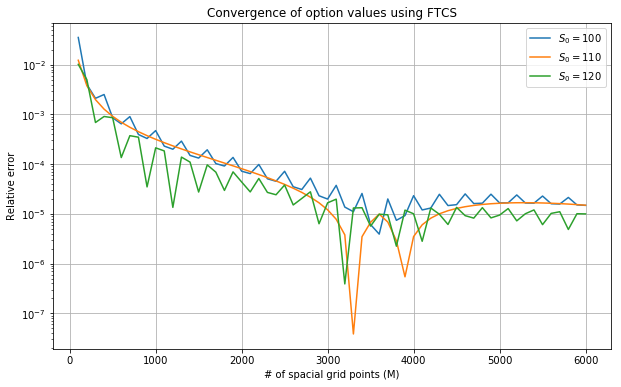

In [43]:
S100,S110,S120 = np.abs((S0_prices-BS_prices[:,None]) / BS_prices[:,None])

plt.figure(figsize=(10,6))
plt.title("Convergence of option values using FTCS")
plt.xlabel("# of spacial grid points (M)")
plt.ylabel("Relative error")

plt.grid(True)
plt.yscale("log")

plt.plot(M_list,S100,label=r'$S_0 = 100$')
plt.plot(M_list,S110,label=r'$S_0 = 110$')
plt.plot(M_list,S120,label=r'$S_0 = 120$')

plt.legend()
plt.show()

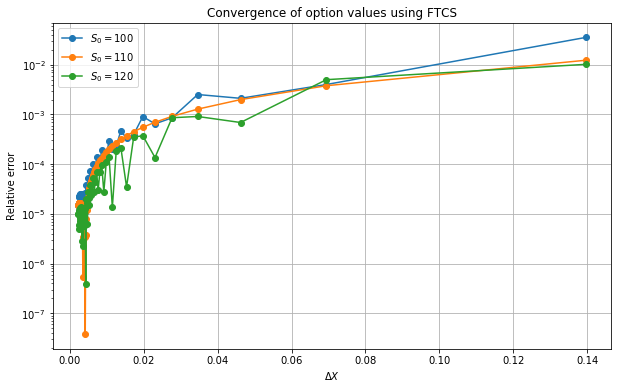

In [44]:
plt.figure(figsize=(10,6))
plt.title("Convergence of option values using FTCS")
plt.xlabel(r"$\Delta X$")
plt.ylabel("Relative error")

plt.grid(True)
plt.yscale("log")

plt.plot(dx_list,S100,'o-',label=r'$S_0 = 100$')
plt.plot(dx_list,S110,'o-',label=r'$S_0 = 110$')
plt.plot(dx_list,S120,'o-',label=r'$S_0 = 120$')

plt.legend()
plt.show()

# Delta calculation

In [45]:
sigma,r,T = 0.3, 0.04, 1
K = 110
S_bounds = 0.001, 1000
N, M = 1000, 2500

#scheme = "FTCS"
scheme = "Crank_Nicolson"
boundary = "Neumann"

pde = PDE(K, sigma, r, T, S_bounds, N, M, scheme, boundary)
pde.run()

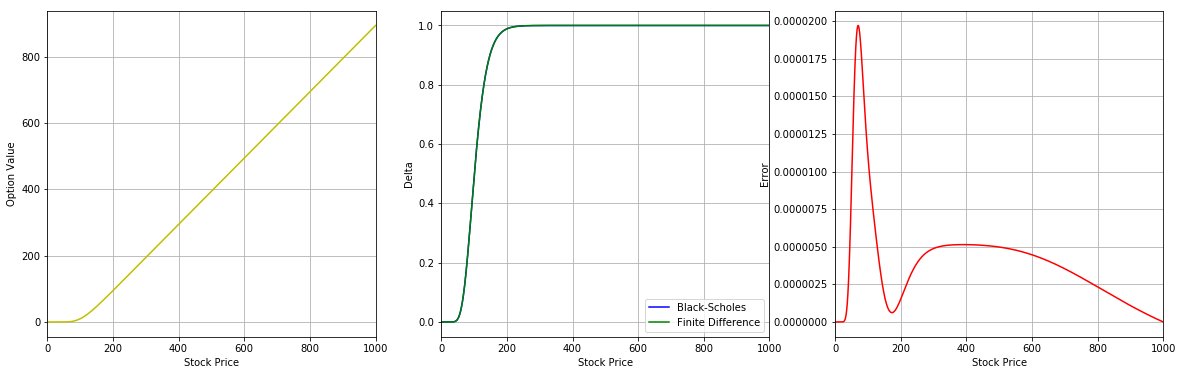

In [46]:
"""
dx = test.dx
V = test.get_values()
N = len(V)
PDE_deltas = np.empty(N)
BS_deltas = np.empty(N)
S = test.get_stock_prices()
for i in range(1, N):
    BS_deltas[i] = black_scholes(r, K, T, S[i], sigma, call=True)[0]
    PDE_deltas[i] = (V[i] - V[i-1]) / (dx * S[i])
"""

S = pde.get_stock_prices()
V = pde.get_values()
PDE_deltas = pde.get_deltas()
BS_deltas, _ = black_scholes(r, K, T, S, sigma)

plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.plot(S, V,  color='y')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.xlim(0,1000)
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(S, BS_deltas, label='Black-Scholes', color='b')
plt.plot(S, PDE_deltas, label='Finite Difference', color='g')
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.xlim(0,1000)
plt.grid()
plt.legend()
plt.subplot(1, 3, 3)
plt.xlabel('Stock Price')
plt.ylabel('Error')
plt.plot(S, (PDE_deltas-BS_deltas), color='r')
plt.xlim(0,1000)
plt.grid()
plt.show()